## Farthest First Traversal Exploration

Author: Brian Lewis

Date: 14 August 2017

The purpose of this notebook is to explore the farthest-first traversal algorithm as a candidate for the selection of representative population points. 

The notebook walks through several examples of the algorithm in action, showcasing its various features and flagging potential downsides.

In [1]:
%matplotlib inline

import geojson
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import shapely

from network_adequacy.representative_population_points import farthest_first_traversal

In [2]:
large_fig_size = [12, 9]
plt.rcParams["figure.figsize"] = large_fig_size

## The Input Data

In [3]:
gdf = gpd.read_file('../../data/USPS/points_94601.geojson')
input_points = gdf['geometry'].values
print('There are {} points in the input data.'.format(len(input_points)))

There are 8722 points in the input data.


## Farthest-First Traversal

### Overview

The farthest first traversal algorithm provides an approximate solution to the metric k-center problem: "Given $n$ cities with specified distances, one wants to build $k$ warehouses in different cities and minimize the maximum distance of a city to a warehouse." 

Intuitively, we want every input population point (city) in a ZIP code to be near to one of the selected representative population points (warehouse). Accordingly, solutions to this problem should make for "good" selections fo representative population points, where "good" remains to be defined.

This greedy solution has an approximation factor of 2 and a runtime of $O(n^2)$.

**Advantages**:
- Sequential choice of points allows for agnosticism about the correct value of $k$ prior to running
- Time complexity $O(n^2)$

**Disadvantages**:
- Sensitivity to outliers
- Element of randomness (selection of first point)
    - This disadvantage can be avoided by choosing the first point deterministically
- Does not treat regions of varying densities differently

Now let's fit the algorithm to our input data and visualize the selected points:

In [4]:
f = farthest_first_traversal.FarthestFirstTraversal(k=100)
f.fit(input_points)

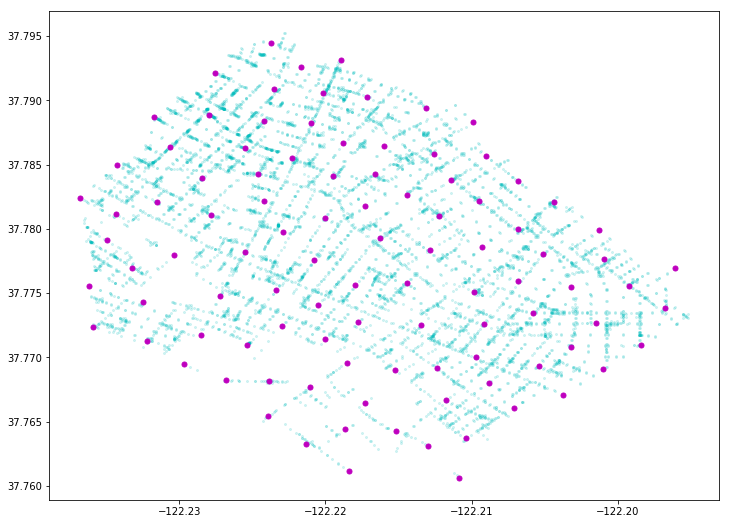

In [5]:
ax = plt.gca();
gdf.plot(ax=ax, color='c', alpha=0.15)
gpd.GeoDataFrame.from_records(
    [(point,) for point in f.selected_points],
    columns=['geometry']
).plot(ax=ax, color='m', markersize=5)

This looks pretty good! Every blue input point has a selected point nearby. 

We can calculate the mean, media, and maximum distances to the selected points (in kilometers):

In [6]:
for metric in ('median', 'mean', 'max'):
    print(
        'The {metric} distance (in kilometers) is {value}.'.format(
            metric=metric,
            value=eval('np.{}(f.distances_to_selected_points)'.format(metric)),
        )
    )

The median distance (in kilometers) is 0.12062865757325902.
The mean distance (in kilometers) is 0.11801730958735365.
The max distance (in kilometers) is 0.2328425116546977.


### Other Features

#### Sequential Point Selection

One nice feature of this algorithm is that it selects a single point at a time. In other words, running the algorithm with $k=100$ and taking the first $50$ points is essentially the same as running the algorithm with $k=50$. 

Note how adding more points produces diminishing returns beyond ~40 points:

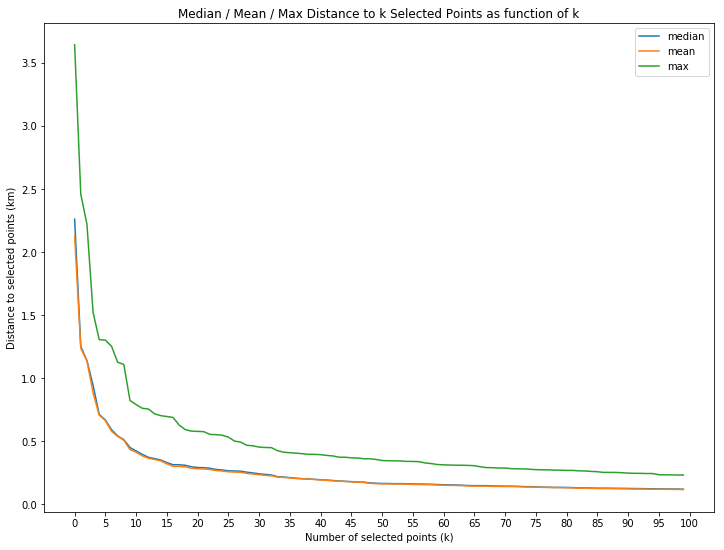

In [7]:
for metric in ('median', 'mean', 'max'):
    vals = eval('[np.{}(d) for d in f._distances_as_function_of_k]'.format(metric))
    plt.plot(vals, label=metric)
plt.legend();
plt.xlabel('Number of selected points (k)')
plt.ylabel('Distance to selected points (km)')
plt.xticks(np.arange(101,step=5));
plt.title('Median / Mean / Max Distance to k Selected Points as function of k');

Let's only plot the first 40 points along with the order in which the points were selected:

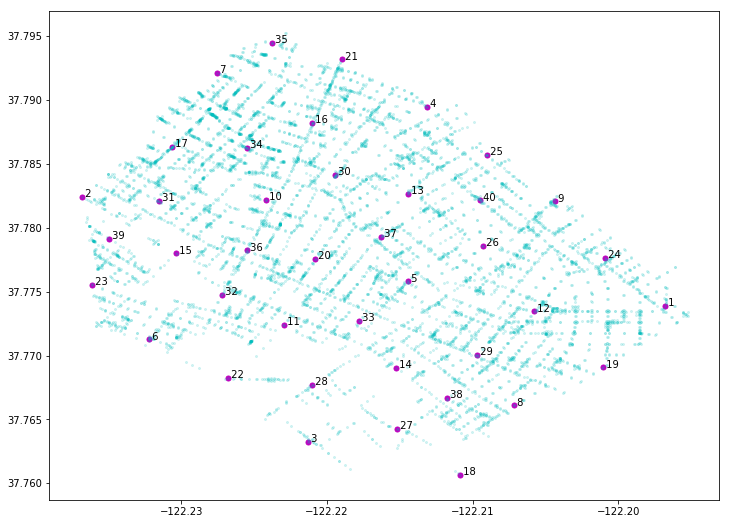

In [8]:
plt.figure();
ax = plt.gca();

xs = [point.coords[0][0] for point in f.selected_points[:40]]
ys = [point.coords[0][1] for point in f.selected_points[:40]]

gdf.plot(ax=ax, color='c', alpha=0.15)

plt.scatter(xs, ys, c='m', s=25)
labels = [' {}'.format(i+1) for i, x in enumerate(xs)]
for x, y, label in zip(xs, ys, labels):
    plt.annotate(label,(x,y))

This still looks pretty reasonable!

This feature of the algorithm means that we can easily and intelligently select a number of representative population points based on the geography of the ZIP code. Once a certain threshold has been reached, we can stop selecting new ones. 

### Clustering

Even though the farthest-first traversal is not explicitly a clustering algorithm, after the data has been fit we can assign each input point to the nearest selected point and thereby obtain a partitioning of the data into $k$ clusters.

Here's what that process looks like in action:

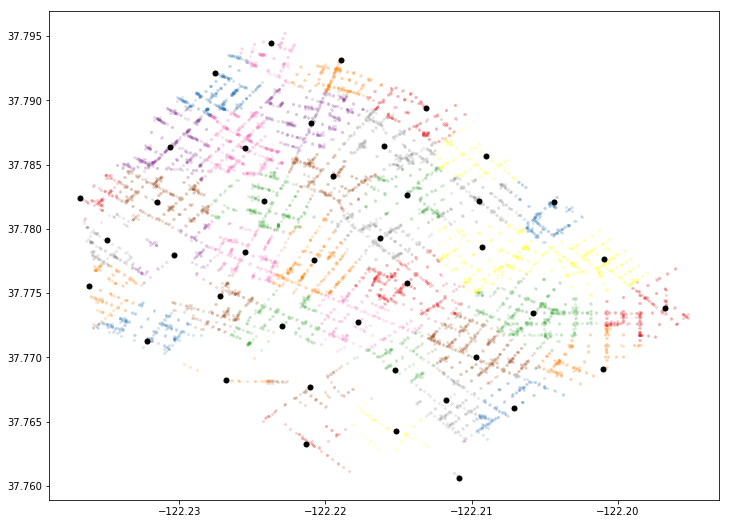

In [9]:
ax = plt.gca();

gdf['assignment'] = f._labels_as_function_of_k[40]
gdf.plot(ax=ax, column='assignment', categorical=True, alpha=0.15)

gpd.GeoDataFrame.from_records(
    [(point,) for point in f.selected_points[:41]],
    columns=['geometry']
).plot(ax=ax, color='k', markersize=5)

#### Sensitivity to Outliers
One not-so-nice feature of farthest-first traversal is that it is highly sensitive to outliers: If the input data has a point far away from the others, this point will almost certainly be selected by the algorithm. 

Let's see this in action with data for another ZIP code:

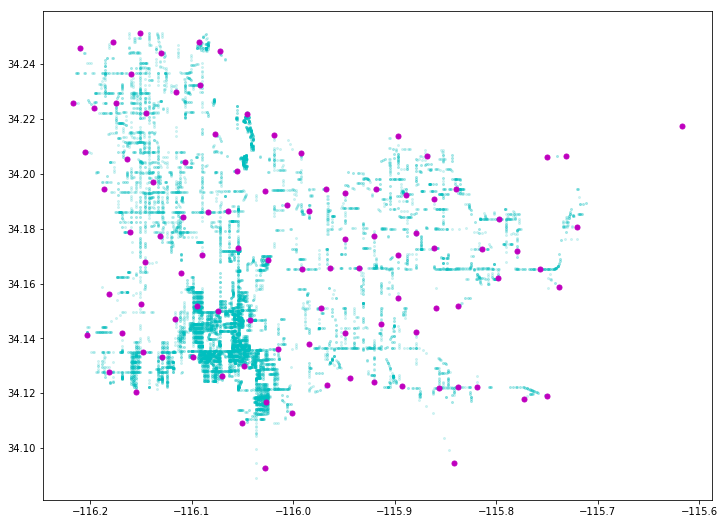

In [10]:
outlier_data = gpd.read_file('../../data/USPS/points_92277.geojson')
f3 = farthest_first_traversal.FarthestFirstTraversal(k=100)
f3.fit(outlier_data['geometry'].values)

ax = plt.gca();
outlier_data.plot(ax=ax, color='c', alpha=0.15)
gpd.GeoDataFrame.from_records(
    [(point,) for point in f3.selected_points],
    columns=['geometry']
).plot(ax=ax, color='m',markersize=5)

Note the point toward the eastern part of the map. This point belongs to a PO box mailing route, but the geography suggests that there is no post office at this point. If there is one here, it's quite inconvenient for the residents of this ZIP code to get to!

Including this point as a representative population point is problematic, since it is likely to be far away from hospitals or primary care providers. A network could certainly be adequate without having to cater to this point in the middle of nowhere.

**TODO**: Investigate removal of outlier points prior to application of the algorithm.

### Other ZIPs

Let's validate the farthest-first traversal algorithm against other ZIP codes with stranger geometrical properties.

There are 12408 points in the input data.


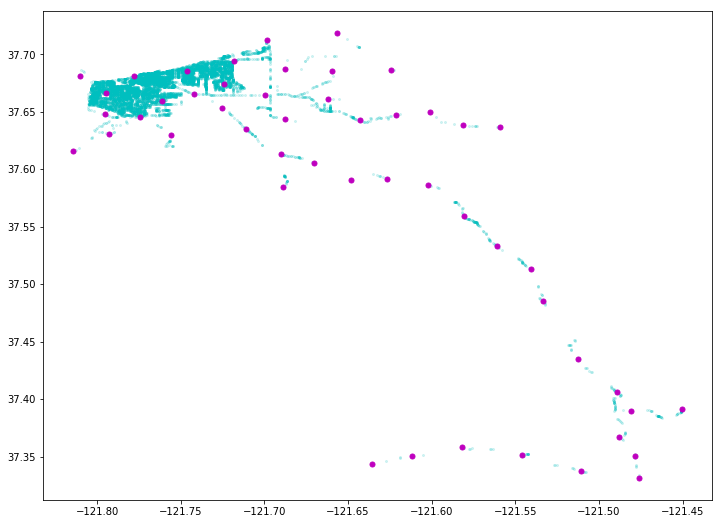

In [11]:
gdf = gpd.read_file('../../data/USPS/points_94550.geojson')
input_points = gdf['geometry'].values
print('There are {} points in the input data.'.format(len(input_points)))
f = farthest_first_traversal.FarthestFirstTraversal(k=50)
f.fit(input_points)
ax = plt.gca();
gdf.plot(ax=ax, color='c', alpha=0.15)
gpd.GeoDataFrame.from_records(
    [(point,) for point in f.selected_points],
    columns=['geometry']
).plot(ax=ax, color='m', markersize=5)

**TODO**: Establish whether or not this is reasonable. 